In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("madrid_spain_Cleansed.csv")
df['host_response_rate'] = (
    pd.to_numeric(
        df['host_response_rate']
        .astype(str)   
        .str.strip()   
        .str.rstrip('%'),
        errors='coerce'  
    )
)
df['host_acceptance_rate'] = (
    pd.to_numeric(
        df['host_acceptance_rate']
        .astype(str)   
        .str.strip()   
        .str.rstrip('%'),
        errors='coerce'  
    )
)

df['host_response_rate'].fillna(0, inplace=True)
df.dropna(subset=['host_response_rate'], inplace=True)

df['host_acceptance_rate'].fillna(0, inplace=True)
df.dropna(subset=['host_acceptance_rate'], inplace=True)

df["host_response_rate"]
df['host_acceptance_rate']

/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_31617/1704500416.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate'].fillna(0, inplace=True)
/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_31617/1704500416.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

0        100
1         32
2          0
3          0
4          0
        ... 
26975      0
26976     99
26977     90
26978     51
26979     89
Name: host_acceptance_rate, Length: 26980, dtype: int64

In [ ]:
def remove_outliers(df, columns, factor=1.5):
    """
    Elimina outliers de las columnas especificadas usando el método IQR.
    
    Parámetros:
      - df: DataFrame a limpiar.
      - columns: Lista de columnas en las que se eliminarán los outliers.
      - factor: Multiplicador del IQR (por defecto 1.5).
      
    Retorna un DataFrame sin los outliers en las columnas indicadas.
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Ejemplo de uso:
# Supongamos que quieres eliminar outliers en las columnas "price", "bathrooms" y "accommodates":
cols_to_clean = ['host_acceptance_rate', 'price', 'host_response_rate', 'accommodates',
               'bathrooms', 'host_is_superhost', 'review_scores_cleanliness',
               'host_identity_verified', 'instant_bookable', 'property_type']
df_clean = remove_outliers(df, cols_to_clean)

# Verifica el tamaño del DataFrame antes y después:
print("Tamaño original:", df.shape)
print("Tamaño limpio:", df_clean.shape)


In [4]:
# Setting dataframes for each room type
dfEntireHome =df[df["room_type"] == "Entire home/apt"]
dfPrivateRoom = df[df["room_type"] == "Private room"]
dfSharedRoom = df[df["room_type"] == "Shared room"]
dfHotelRoom = df[df["room_type"] == "Hotel room"]


# Regresion Lineal Simple


In [5]:
# ============================
# Funciones de Preprocesamiento
# ============================
def convert_percentage(serie):
    """Convierte cadenas con '%' a valores numéricos."""
    return pd.to_numeric(serie.astype(str).str.strip().str.rstrip('%'), errors='coerce')

def preprocess_df(df):
    if 'host_response_rate' in df.columns:
        df['host_response_rate'] = convert_percentage(df['host_response_rate'])
        df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace=True)
    if 'host_acceptance_rate' in df.columns:
        df['host_acceptance_rate'] = convert_percentage(df['host_acceptance_rate'])
        df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean(), inplace=True)
    
    for col in ['host_is_superhost', 'host_identity_verified', 'instant_bookable']:
        if col in df.columns:
            df[col] = df[col].replace({"t": 1, "f": 0})
    
    if 'property_type' in df.columns and df["property_type"].dtype == object:
        propertyCounts = df["property_type"].value_counts()
        propertyRank = propertyCounts.rank(method='dense', ascending=False).astype(int)
        rank_mapping = propertyRank.to_dict()
        df["property_type"] = df["property_type"].map(rank_mapping)
    
    return df

# ============================
# Cargar y Preprocesar Datos
# ============================
df = pd.read_csv("madrid_spain_Cleansed.csv")

df = preprocess_df(df)

# Filtrar por tipo de habitación para crear subconjuntos
dfEntireHome = df[df["room_type"] == "Entire home/apt"].copy()
dfPrivateRoom  = df[df["room_type"] == "Private room"].copy()
dfSharedRoom   = df[df["room_type"] == "Shared room"].copy()
dfHotelRoom = df[df["room_type"] == "Hotel room"].copy()

cols_to_use = ['host_acceptance_rate', 'price', 'host_response_rate', 'accommodates',
               'bathrooms', 'host_is_superhost', 'review_scores_cleanliness',
               'host_identity_verified', 'instant_bookable', 'property_type']

dfEntireHome = dfEntireHome[cols_to_use].copy()
dfPrivateRoom = dfPrivateRoom[cols_to_use].copy()
dfSharedRoom  = dfSharedRoom[cols_to_use].copy()
dfHotelRoom = dfHotelRoom[cols_to_use].copy()

# ============================
# Función para Regresión Lineal Simple
# ============================
def plot_simple_regression(dataframe, indep_col, dep_col="price", title=None):
    X = dataframe[[indep_col]]
    y = dataframe[dep_col]
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    df_plot = dataframe.copy()
    df_plot["pred"] = y_pred
    df_plot = df_plot.sort_values(indep_col)
    
    if title is None:
        title = f"Regresión Simple: {indep_col} vs {dep_col}"
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df_plot[indep_col], y=df_plot[dep_col], color="blue", label="Datos reales")
    sns.scatterplot(x=df_plot[indep_col], y=df_plot["pred"], color="red", label="Predicción")
    plt.title(title)
    plt.xlabel(indep_col)
    plt.ylabel(dep_col)
    plt.legend()
    plt.show()
    
    r2 = model.score(X, y)
    print(f"Coeficiente de determinación (R²): {r2}")
    print(f"Coeficiente de correlación (sqrt(R²)): {np.sqrt(r2)}")




/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_31617/407904613.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace=True)
/var/folders/p0/qzxt_2qj2wqcvfvmsw_vz06c0000gn/T/ipykernel_31617/407904613.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

# Entire Home

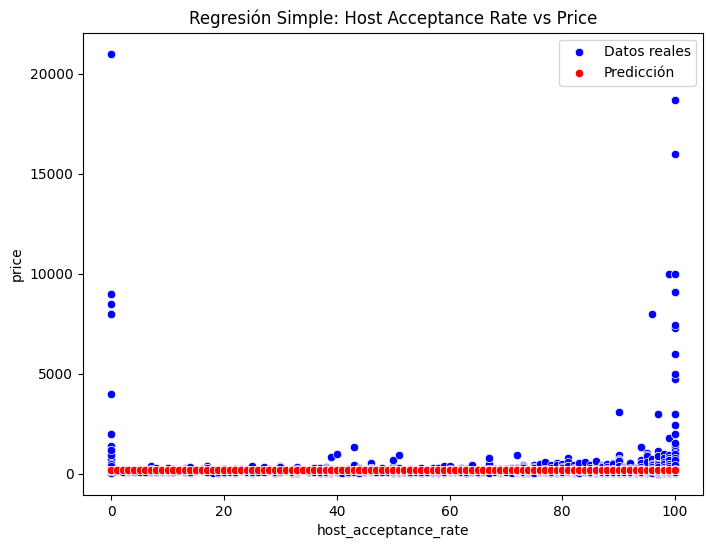

Coeficiente de determinación (R²): 2.0582505699917597e-05
Coeficiente de correlación (sqrt(R²)): 0.004536794650402153


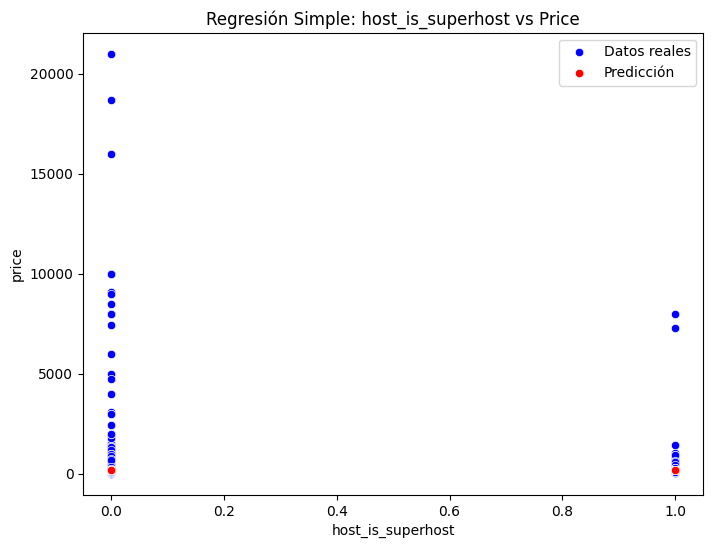

Coeficiente de determinación (R²): 2.214587861004702e-05
Coeficiente de correlación (sqrt(R²)): 0.004705940778425396


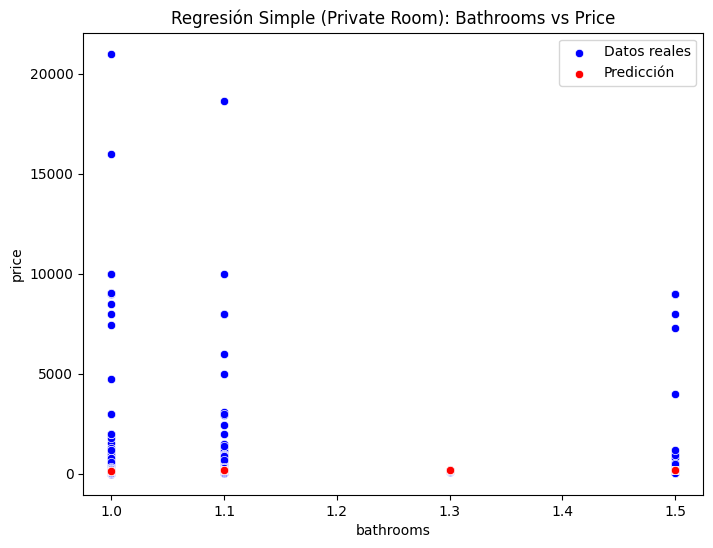

Coeficiente de determinación (R²): 0.0004365365477708716
Coeficiente de correlación (sqrt(R²)): 0.020893457056477552


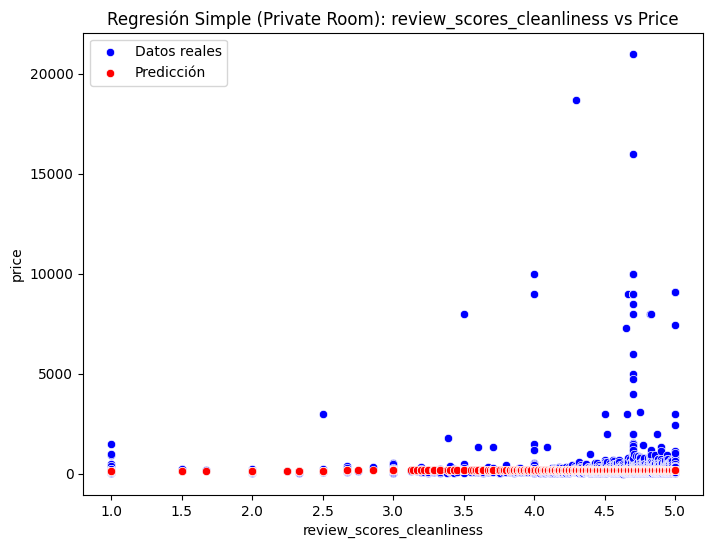

Coeficiente de determinación (R²): 1.0106604312221101e-05
Coeficiente de correlación (sqrt(R²)): 0.003179088597730661


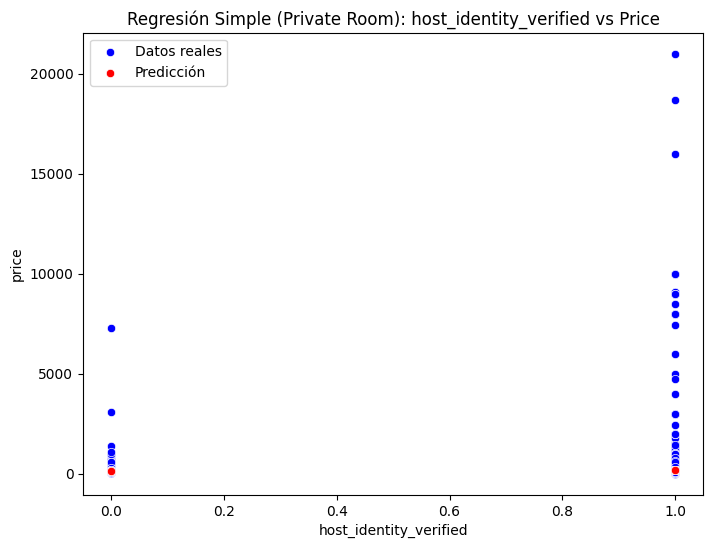

Coeficiente de determinación (R²): 2.664734419977055e-05
Coeficiente de correlación (sqrt(R²)): 0.005162106566099788


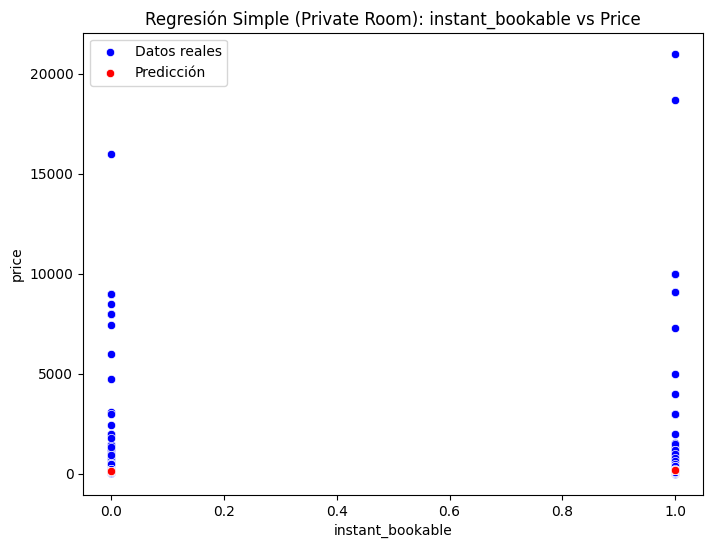

Coeficiente de determinación (R²): 0.0005436989564100436
Coeficiente de correlación (sqrt(R²)): 0.0233173531175827


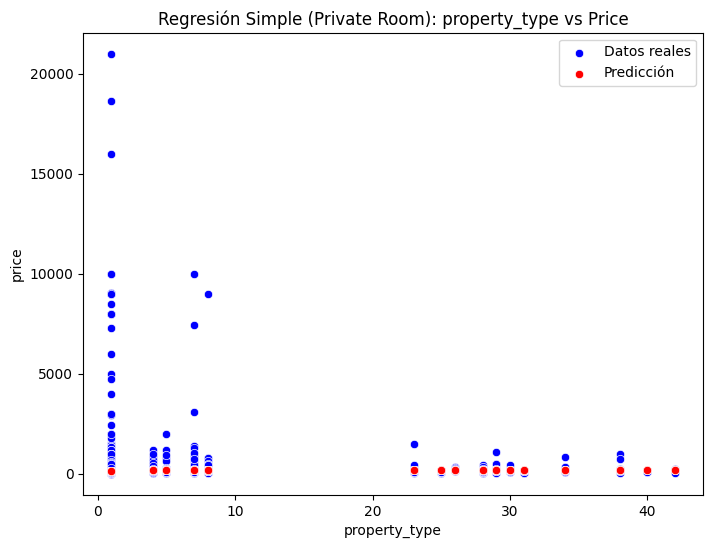

Coeficiente de determinación (R²): 3.5995468845140266e-05
Coeficiente de correlación (sqrt(R²)): 0.0059996223918793645


In [10]:
# Entire Home 
# 
plot_simple_regression(dfEntireHome, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfEntireHome, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfEntireHome, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfEntireHome, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfEntireHome, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfEntireHome, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfEntireHome, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Private Room

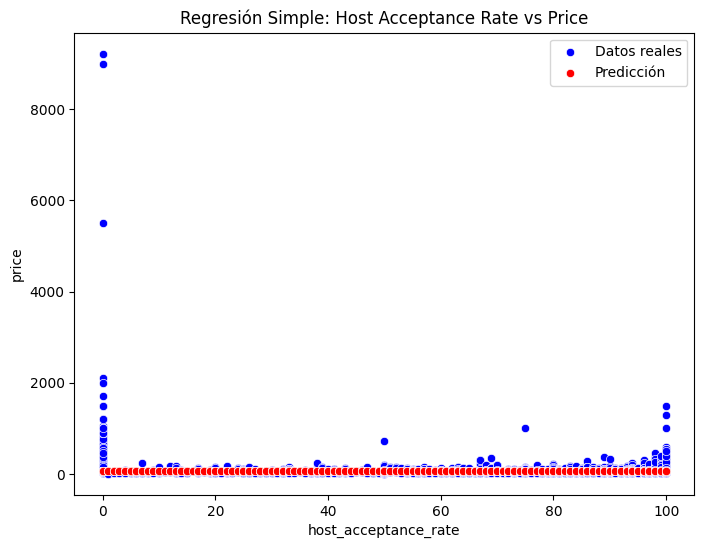

Coeficiente de determinación (R²): 0.0020780589352142886
Coeficiente de correlación (sqrt(R²)): 0.04558573170647027


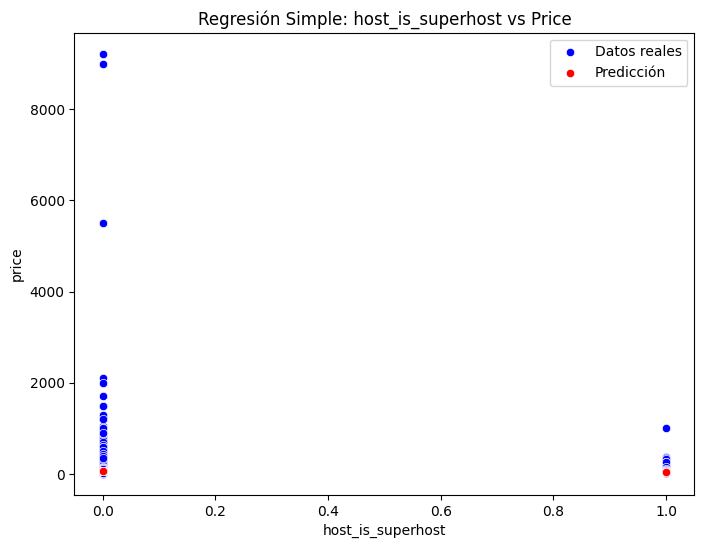

Coeficiente de determinación (R²): 0.0013532898855791453
Coeficiente de correlación (sqrt(R²)): 0.03678708857165983


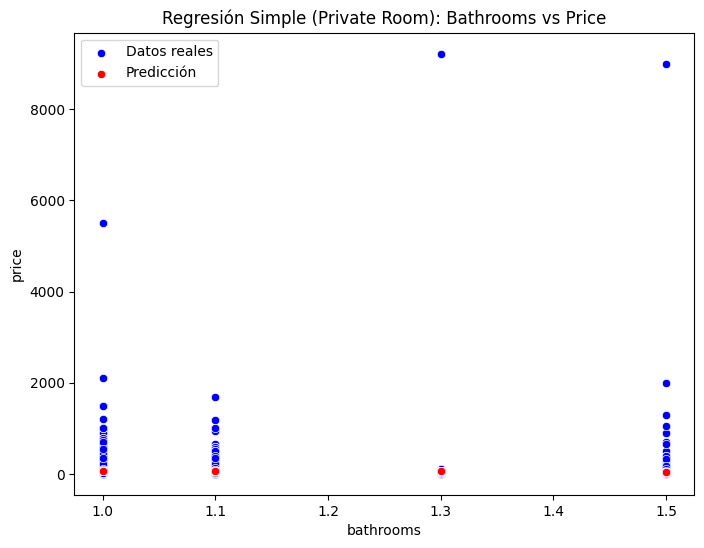

Coeficiente de determinación (R²): 0.0012551481505465034
Coeficiente de correlación (sqrt(R²)): 0.03542807009345137


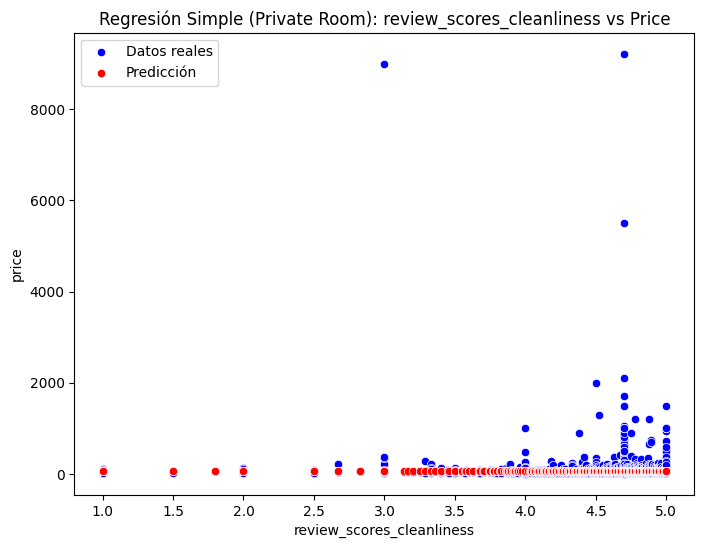

Coeficiente de determinación (R²): 5.467824310922964e-05
Coeficiente de correlación (sqrt(R²)): 0.0073944738223371675


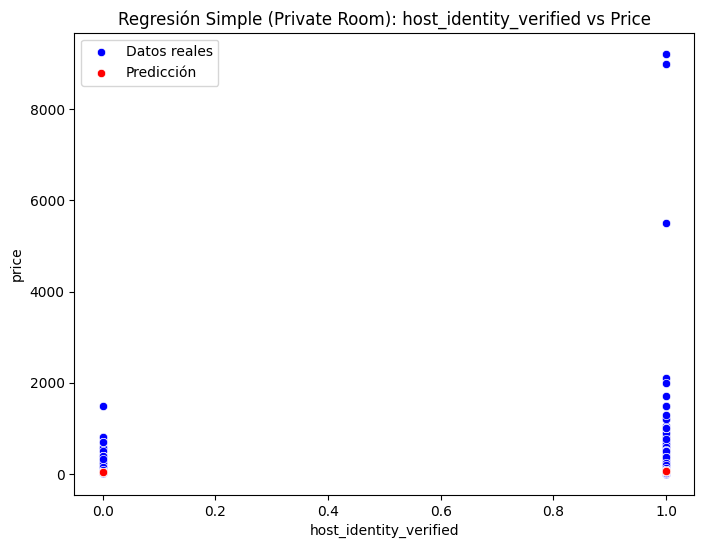

Coeficiente de determinación (R²): 0.0008727447297052215
Coeficiente de correlación (sqrt(R²)): 0.029542253294310872


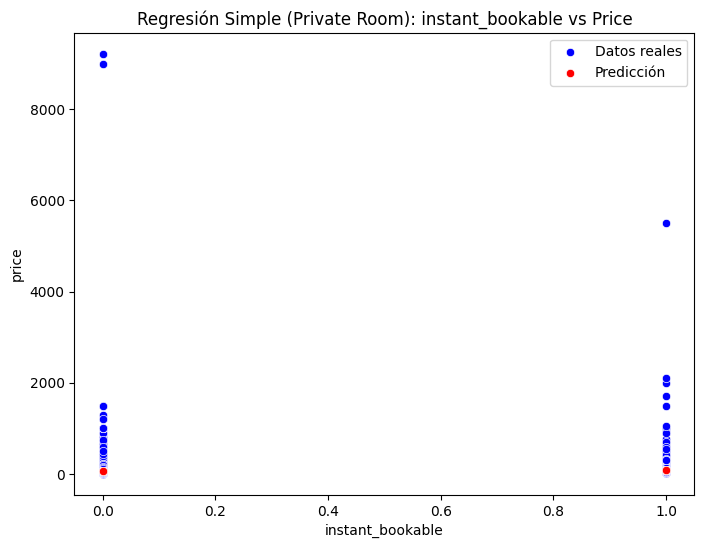

Coeficiente de determinación (R²): 0.006016752510702439
Coeficiente de correlación (sqrt(R²)): 0.07756772853901575


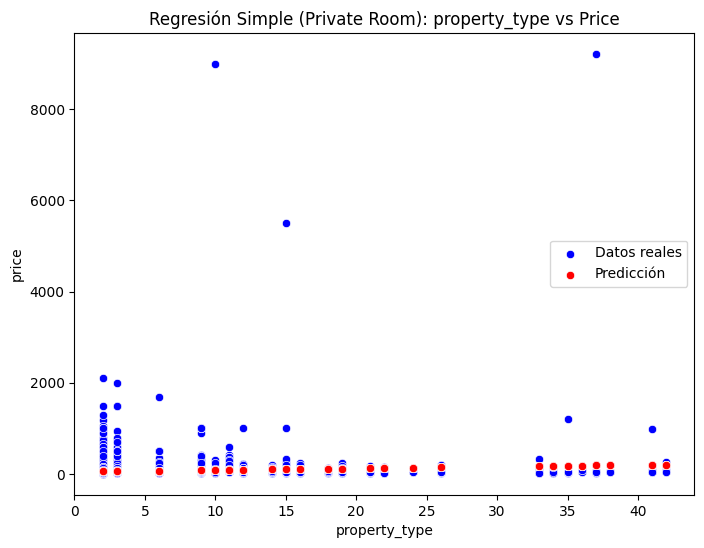

Coeficiente de determinación (R²): 0.011031520716681786
Coeficiente de correlación (sqrt(R²)): 0.10503104644190586


In [11]:
# Private Room
plot_simple_regression(dfPrivateRoom, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfPrivateRoom, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfPrivateRoom, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfPrivateRoom, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Shared Room

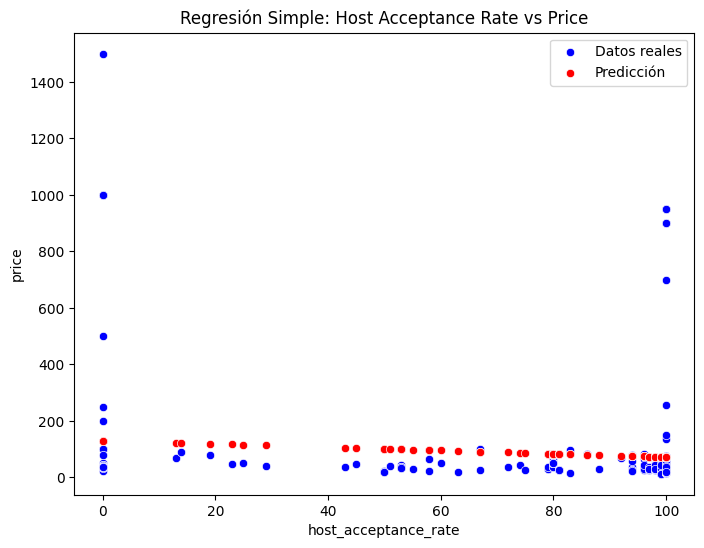

Coeficiente de determinación (R²): 0.012755933287429966
Coeficiente de correlación (sqrt(R²)): 0.11294216788883576


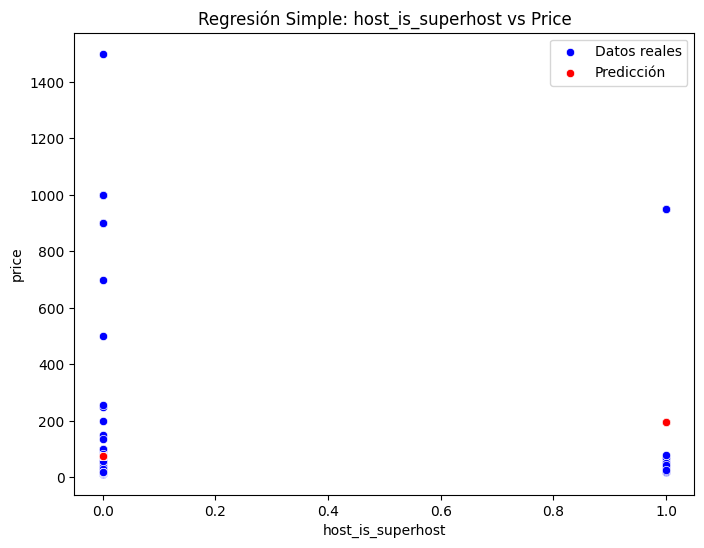

Coeficiente de determinación (R²): 0.029837426545453627
Coeficiente de correlación (sqrt(R²)): 0.17273513407947333


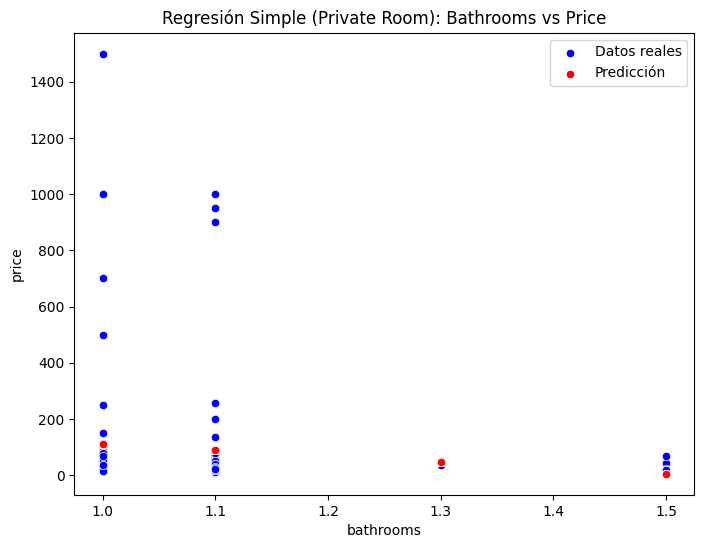

Coeficiente de determinación (R²): 0.014466668730219512
Coeficiente de correlación (sqrt(R²)): 0.12027746559609373


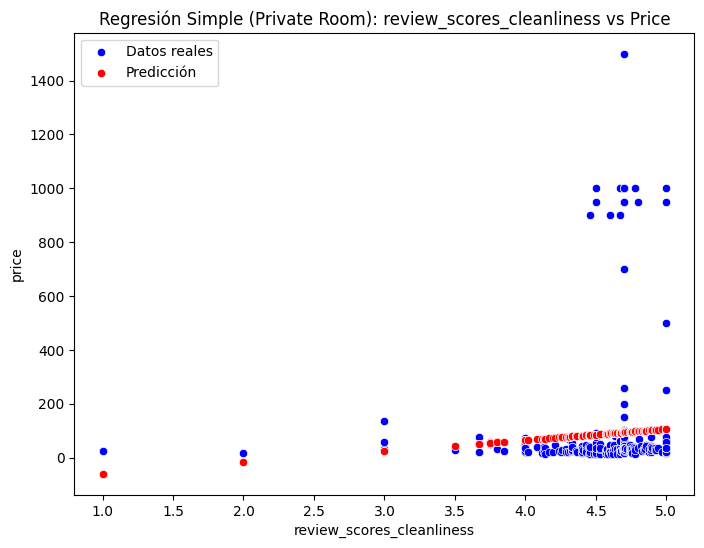

Coeficiente de determinación (R²): 0.0058108209880201045
Coeficiente de correlación (sqrt(R²)): 0.0762287412202255


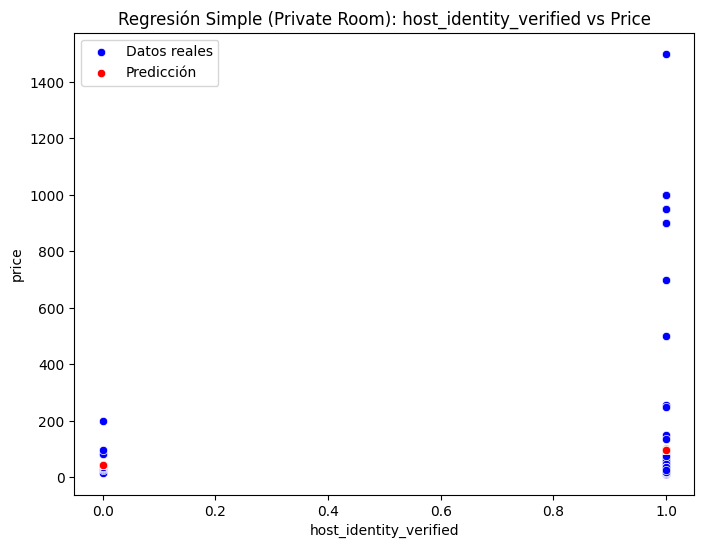

Coeficiente de determinación (R²): 0.006143299233880795
Coeficiente de correlación (sqrt(R²)): 0.07837920153893375


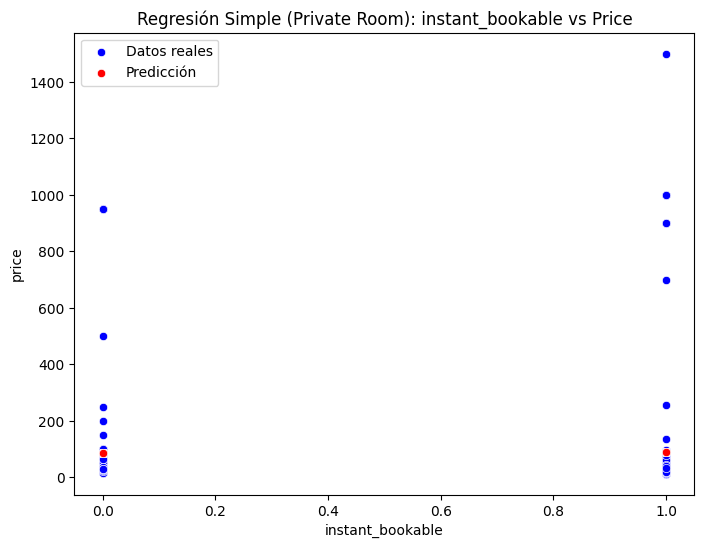

Coeficiente de determinación (R²): 0.00015618863778965597
Coeficiente de correlación (sqrt(R²)): 0.012497545270558373


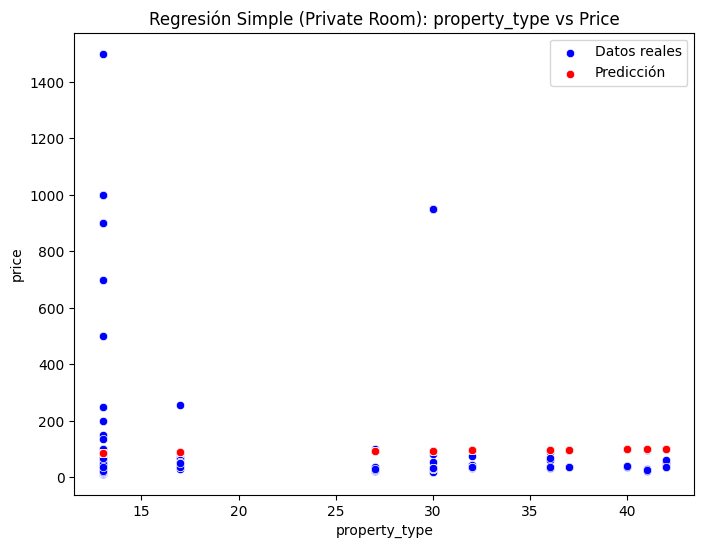

Coeficiente de determinación (R²): 0.0004194436309093996
Coeficiente de correlación (sqrt(R²)): 0.02048032301770164


In [12]:
# Private Room
plot_simple_regression(dfSharedRoom, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfSharedRoom, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfSharedRoom, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfSharedRoom, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfSharedRoom, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfSharedRoom, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfSharedRoom, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Hotel Room

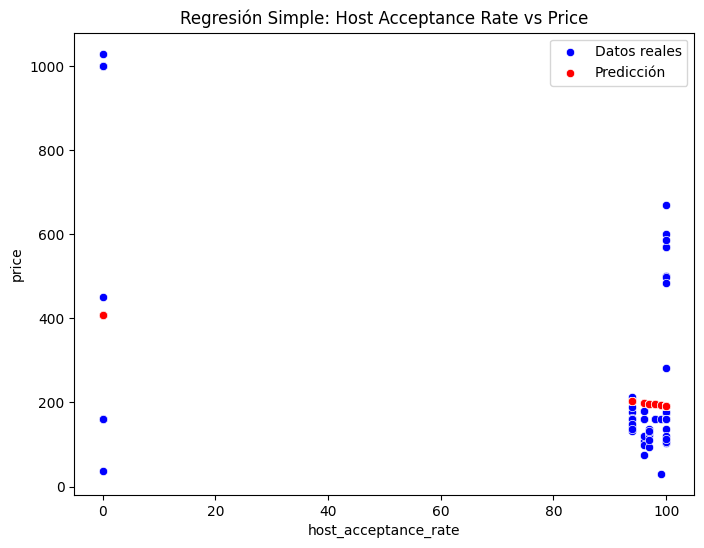

Coeficiente de determinación (R²): 0.14209772860962744
Coeficiente de correlación (sqrt(R²)): 0.37695852372592326


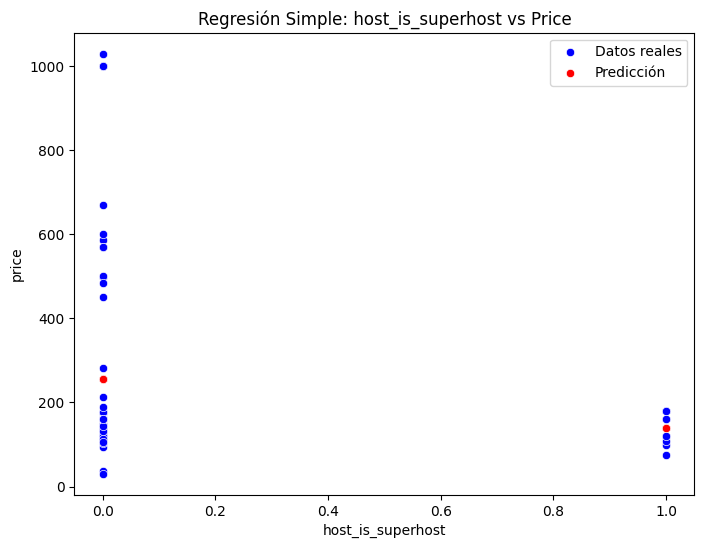

Coeficiente de determinación (R²): 0.02398536053243594
Coeficiente de correlación (sqrt(R²)): 0.15487207796254282


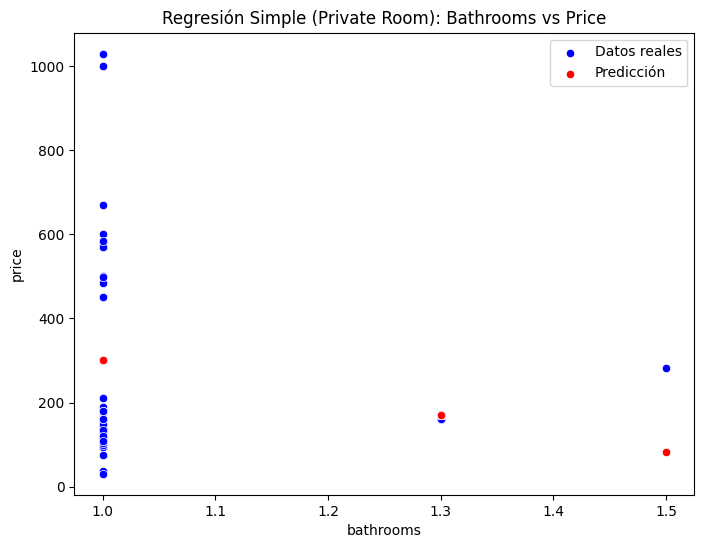

Coeficiente de determinación (R²): 0.08059426670602865
Coeficiente de correlación (sqrt(R²)): 0.2838912938186528


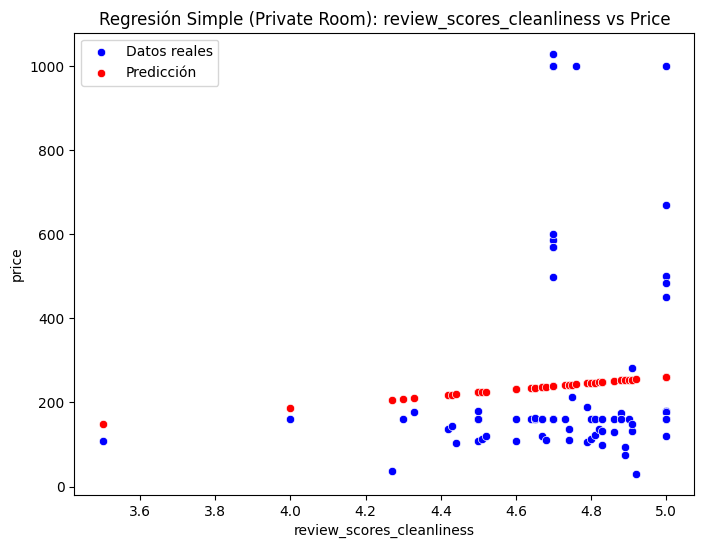

Coeficiente de determinación (R²): 0.005835157217781606
Coeficiente de correlación (sqrt(R²)): 0.07638820077591568


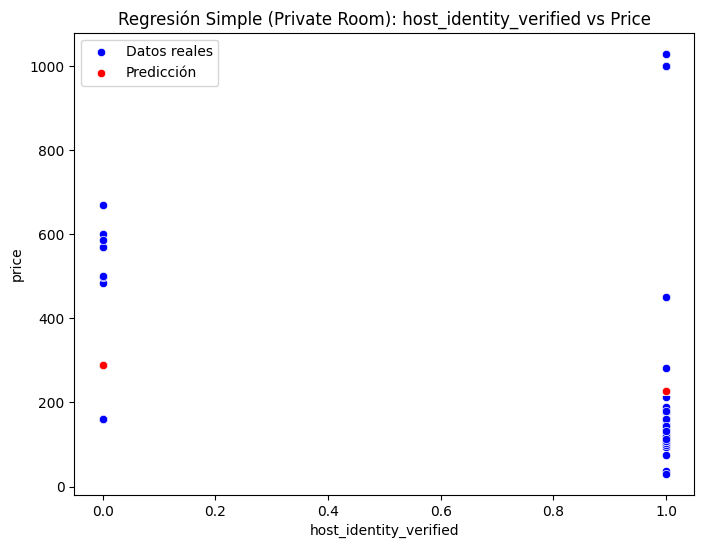

Coeficiente de determinación (R²): 0.013785790381049656
Coeficiente de correlación (sqrt(R²)): 0.11741290551319158


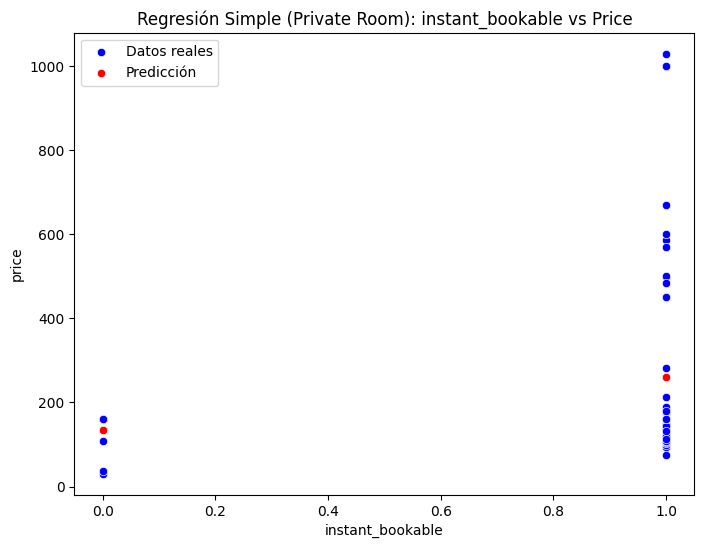

Coeficiente de determinación (R²): 0.03115757149027809
Coeficiente de correlación (sqrt(R²)): 0.17651507439954836


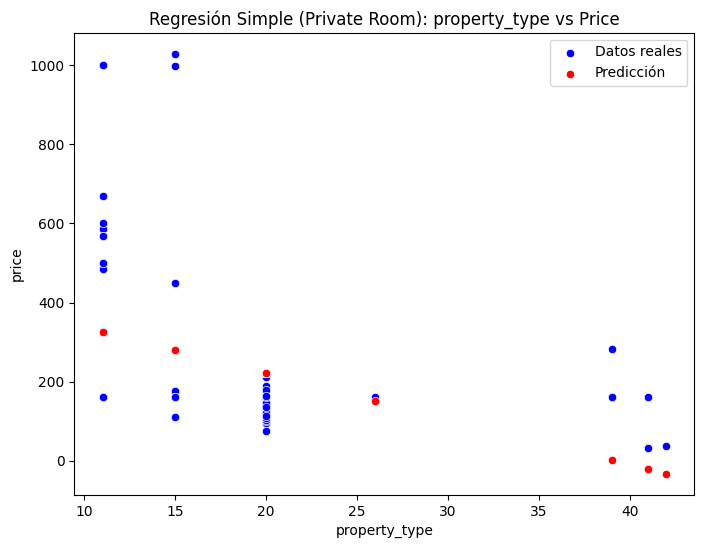

Coeficiente de determinación (R²): 0.12934372294462826
Coeficiente de correlación (sqrt(R²)): 0.3596438835078782


In [13]:
# Private Room
plot_simple_regression(dfHotelRoom, indep_col="host_acceptance_rate", dep_col="price",
                       title="Regresión Simple: Host Acceptance Rate vs Price")

# Ejemplo 2: Usar dfEntireHome y comparar usando "property_type" en el eje X
plot_simple_regression(dfHotelRoom, indep_col="host_is_superhost", dep_col="price",
                       title="Regresión Simple: host_is_superhost vs Price")

# Ejemplo 3: Usar dfPrivateRoom y comparar usando "host_acceptance_rate" en el eje X
plot_simple_regression(dfHotelRoom, indep_col="bathrooms", dep_col="price",
                       title="Regresión Simple (Private Room): Bathrooms vs Price")

plot_simple_regression(dfHotelRoom, indep_col="review_scores_cleanliness", dep_col="price",
                       title="Regresión Simple (Private Room): review_scores_cleanliness vs Price")

plot_simple_regression(dfHotelRoom, indep_col="host_identity_verified", dep_col="price",
                       title="Regresión Simple (Private Room): host_identity_verified vs Price")

plot_simple_regression(dfHotelRoom, indep_col="instant_bookable", dep_col="price",
                       title="Regresión Simple (Private Room): instant_bookable vs Price")

plot_simple_regression(dfHotelRoom, indep_col="property_type", dep_col="price",
                       title="Regresión Simple (Private Room): property_type vs Price")

# Regresión Multiple 

In [14]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

def plot_multiple_regression_single_x(dataframe, indep_cols, dep_col="price", plot_indep_col=None, overall_title="Regresión Múltiple"):
    if plot_indep_col is None:
        raise ValueError("Debes especificar una columna para el eje X (plot_indep_col).")
    
    X = dataframe[indep_cols]
    y = dataframe[dep_col]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    df_plot = dataframe.copy()
    df_plot["pred"] = y_pred
    df_plot = df_plot.sort_values(plot_indep_col)
    
    r2 = model.score(X, y)
    print(f"Coeficiente de determinación (R²): {r2}")
    print(f"Coeficiente de correlación (sqrt(R²)): {np.sqrt(r2)}")
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df_plot[plot_indep_col], y=df_plot[dep_col], color="blue", label="Datos reales")
    sns.scatterplot(x=df_plot[plot_indep_col], y=df_plot["pred"], color="red", label="Datos Predichos")
    plt.title(overall_title)
    plt.xlabel(plot_indep_col)
    plt.ylabel(dep_col)
    plt.legend()
    plt.show()

# Host acceptance rate

Coeficiente de determinación (R²): 0.01994395226201251
Coeficiente de correlación (sqrt(R²)): 0.14122305853511496


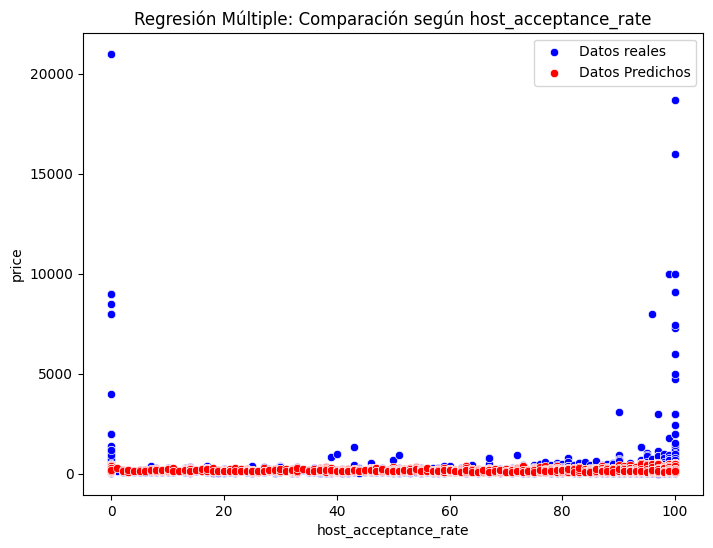

In [15]:
indep_vars = ["host_acceptance_rate", "instant_bookable", "host_is_superhost", "accommodates"]
plot_variable = "host_acceptance_rate"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según host_acceptance_rate")

# Host is superhost

Coeficiente de determinación (R²): 0.0004875211594379536
Coeficiente de correlación (sqrt(R²)): 0.022079881327533298


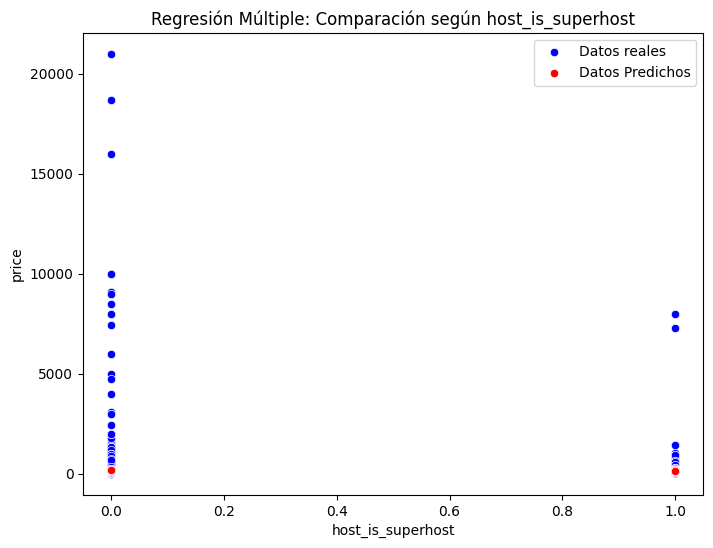

In [16]:
indep_vars = ["host_acceptance_rate", "bathrooms", "host_is_superhost", "property_type"]
plot_variable = "host_is_superhost"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según host_is_superhost")

# Bathrooms

Coeficiente de determinación (R²): 0.01956685662539215
Coeficiente de correlación (sqrt(R²)): 0.13988158072238155


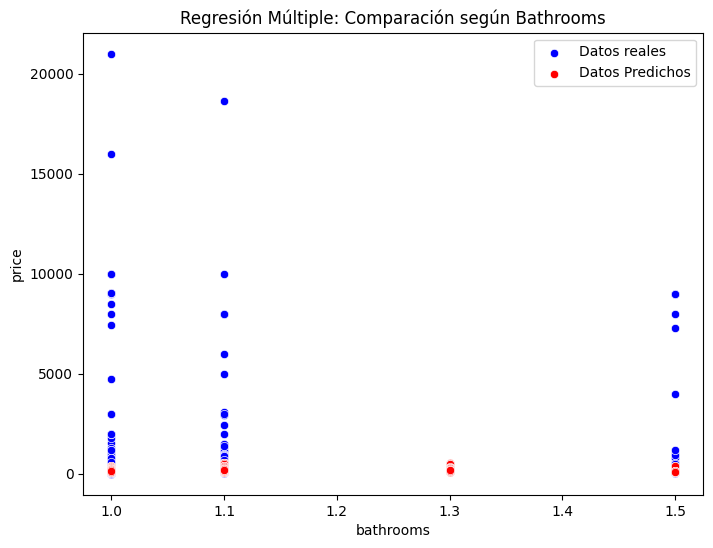

In [17]:

indep_vars = ["host_acceptance_rate", "bathrooms", "host_is_superhost", "accommodates"]
plot_variable = "bathrooms"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según Bathrooms")

# Review Scores cleanliness

Coeficiente de determinación (R²): 0.01927116215074265
Coeficiente de correlación (sqrt(R²)): 0.1388206114045845


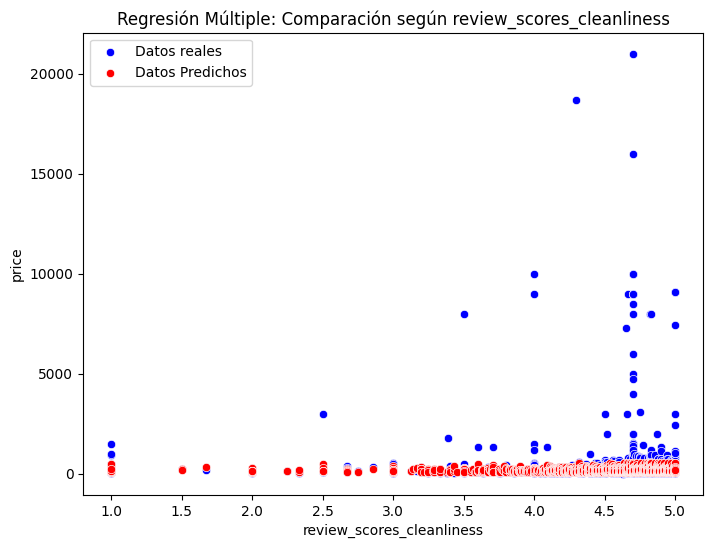

In [18]:
indep_vars = ["bathrooms", "accommodates", "property_type", "review_scores_cleanliness"]
plot_variable = "review_scores_cleanliness"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según review_scores_cleanliness")

# Host identity verified

Coeficiente de determinación (R²): 0.000634958467368385
Coeficiente de correlación (sqrt(R²)): 0.025198382237127545


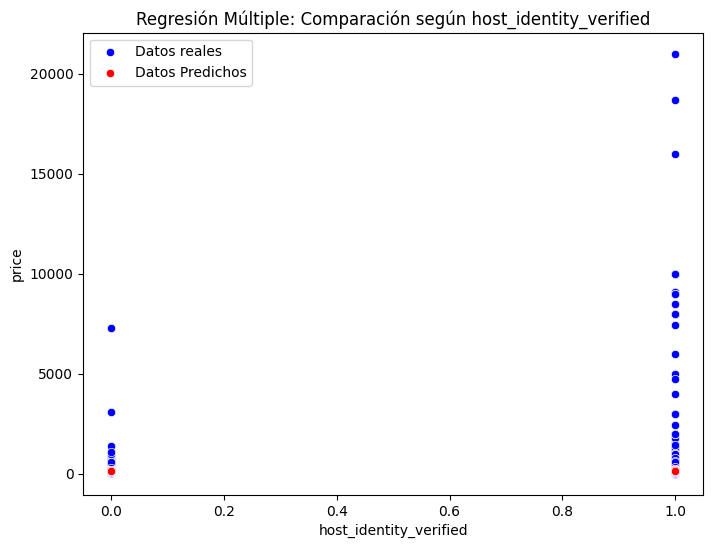

In [19]:
indep_vars = ["host_is_superhost", "property_type", "host_identity_verified", "instant_bookable"]
plot_variable = "host_identity_verified"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según host_identity_verified")

# Instant Bookable

Coeficiente de determinación (R²): 0.019341371716635414
Coeficiente de correlación (sqrt(R²)): 0.13907326025025593


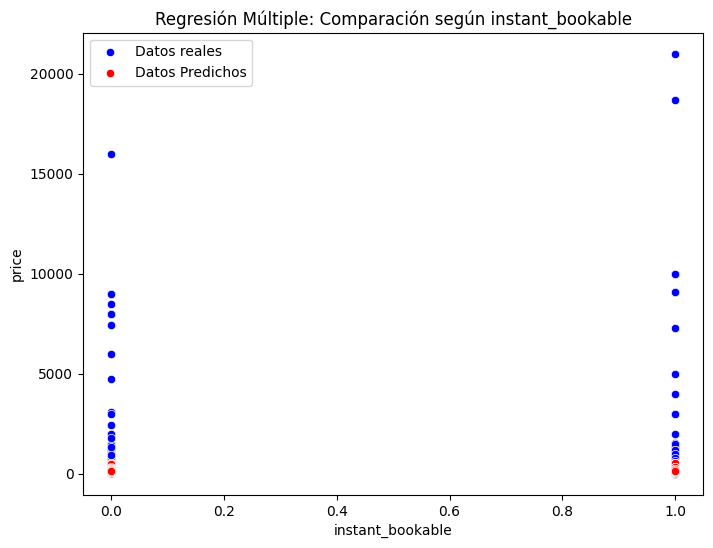

In [20]:
indep_vars = ["accommodates", "property_type", "host_identity_verified", "instant_bookable"]
plot_variable = "instant_bookable"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según instant_bookable")

# Property Type

Coeficiente de determinación (R²): 0.019387434192989383
Coeficiente de correlación (sqrt(R²)): 0.13923876684669892


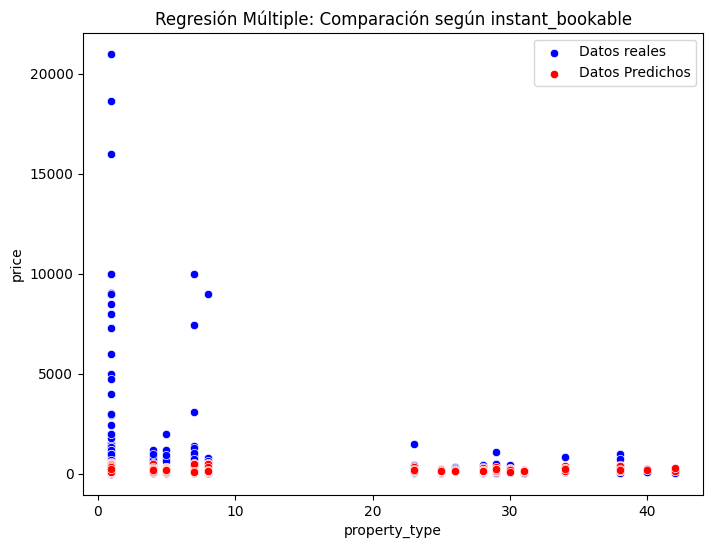

In [21]:
indep_vars = ["accommodates", "property_type", "review_scores_cleanliness", "instant_bookable"]
plot_variable = "property_type"  # La variable única a comparar en el eje X

plot_multiple_regression_single_x(dfEntireHome, indep_cols=indep_vars, dep_col="price", plot_indep_col=plot_variable,
                                  overall_title="Regresión Múltiple: Comparación según instant_bookable")

/Users/alanvalerdi/Developer/HomeWork/Inteligencia_De_Negocios/inteligenciaDeNegociosVenv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alanvalerdi/Developer/HomeWork/Inteligencia_De_Negocios/inteligenciaDeNegociosVenv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alanvalerdi/Developer/HomeWork/Inteligencia_De_Negocios/inteligenciaDeNegociosVenv/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

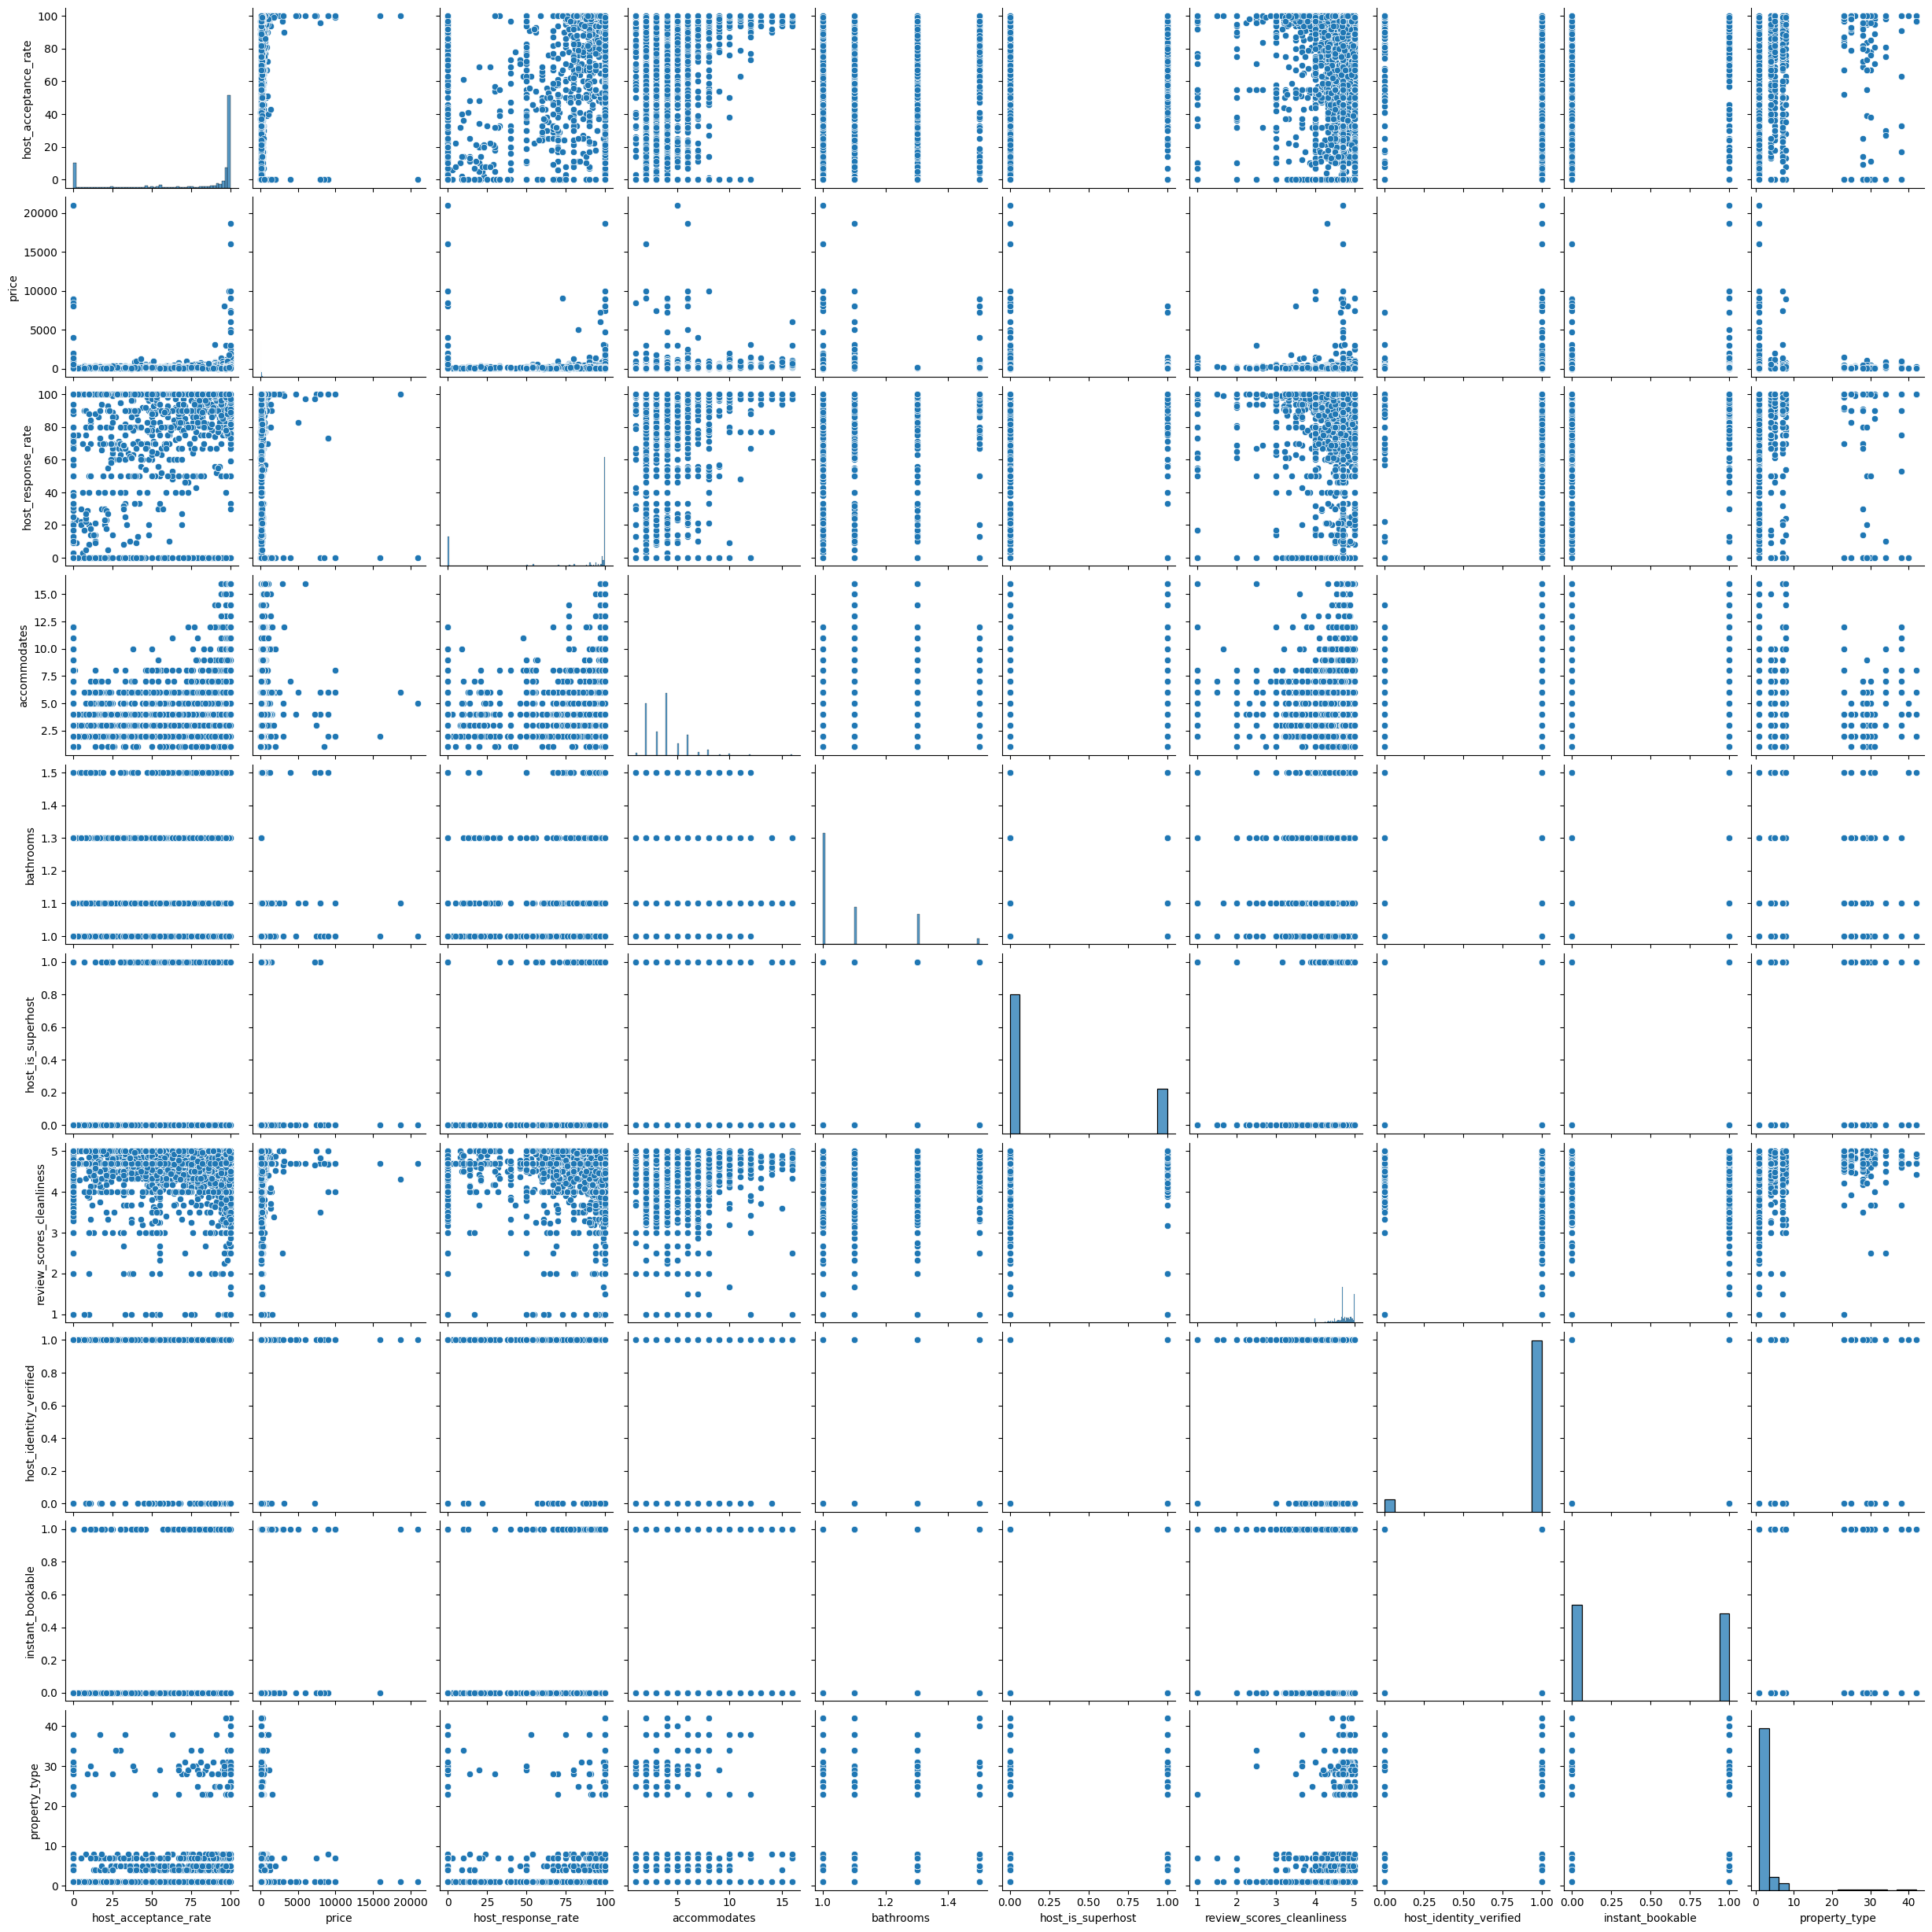

In [107]:
sns.pairplot(dfEntireHome)

# Graficas de Correlaciones para cada DataFrame

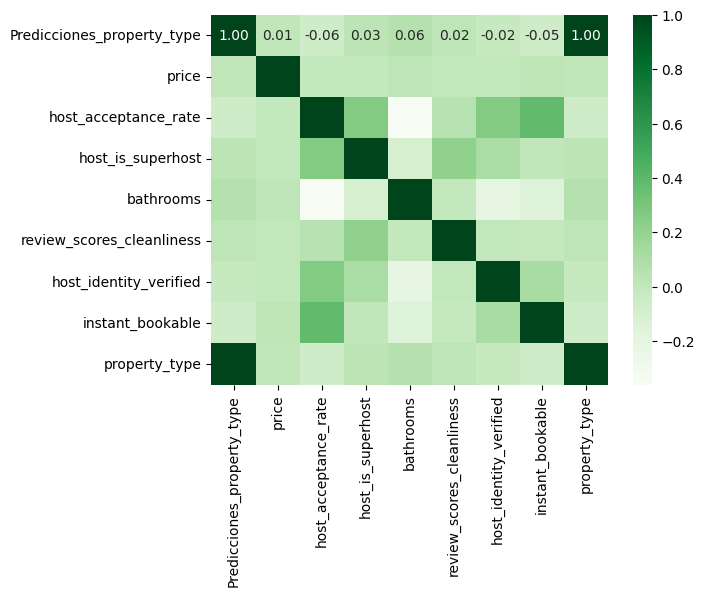

In [ ]:
corrFactorsEntireHome = dfEntireHomeCuantity.corr()
corrFactorsEntireHome1 = abs(corrFactorsEntireHome) 
heatMapCorrFactorsEntireHome = sns.heatmap(corrFactorsEntireHome, cmap="Greens", annot=True, fmt=".2f")

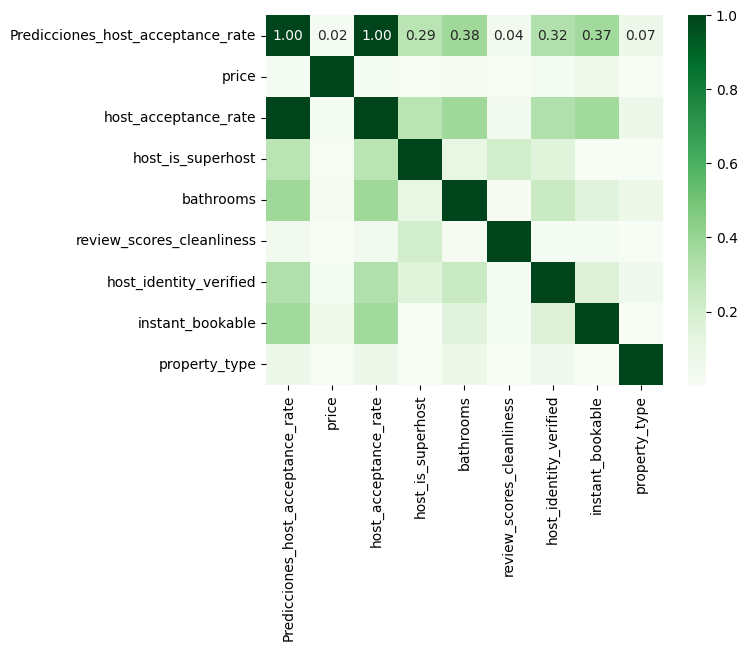

In [38]:
corrFactorsEntireHome = df.corr()
corrFactorsEntireHome1 = abs(corrFactorsEntireHome)
heatMapCorrFactorsEntireHome = sns.heatmap(corrFactorsEntireHome1, cmap="Greens", annot=True, fmt=".2f")